## Initialisation

In [2]:
!pip install transformers
!pip install tensorflow==2.2.0
!pip install nibabel

import torch
import numpy
import math
import nibabel

from transformers import GPT2Tokenizer, GPT2LMHeadModel
from scipy.special import softmax
from scipy.stats import pearsonr
from matplotlib import pyplot


tokenizer = GPT2Tokenizer.from_pretrained('gpt2-medium')
model = GPT2LMHeadModel.from_pretrained("gpt2-medium")

     |████████████████████████████████| 1.9MB 6.8MB/s 
     |████████████████████████████████| 3.2MB 27.5MB/s 
     |████████████████████████████████| 890kB 43.2MB/s 
  Created wheel for sacremoses: filename=sacremoses-0.0.43-cp37-none-any.whl size=893262 sha256=71eb73e7acb72c02552a66cc1e6b3915d094121d0d010fea19ecc4820dadc2f7
  Stored in directory: /root/.cache/pip/wheels/29/3c/fd/7ce5c3f0666dab31a50123635e6fb5e19ceb42ce38d4e58f45
Successfully built sacremoses
     |████████████████████████████████| 516.2MB 29kB/s 
     |████████████████████████████████| 3.0MB 49.1MB/s 
     |████████████████████████████████| 460kB 36.7MB/s 
  Found existing installation: tensorboard 2.4.1
    Uninstalling tensorboard-2.4.1:
      Successfully uninstalled tensorboard-2.4.1
  Found existing installation: tensorflow-estimator 2.4.0
    Uninstalling tensorflow-estimator-2.4.0:
      Successfully uninstalled tensorflow-estimator-2.4.0
  Found existing installation: tensorflow 2.4.1
    Uninstalling tensorf

## Language Model (GPT-2)

In [13]:
# Load file
file = open('/content/drive/MyDrive/Project Files/annotations.tsv', 'r', encoding='utf-8')
partsList = []
sliceSurprisalList = {-1: -1}

for number in range(20, 744, 2):
    sliceSurprisalList[number] = -1

# Read data from file, and store data as matrix
for line in file:
    allLineParts = line.split("\t")

    if line.__contains__('Word Onset'):
        pass
    else:

        if allLineParts[1] == '' or allLineParts[2] == '':
            # Set -1 as a designated value when there are no start times or end times
            timeSlice = -1
        else:
            # Calculate time slice of each word
            startTime = float(allLineParts[1])
            endTime = float(allLineParts[2])
            timeSecond = math.floor(startTime + ((endTime - startTime) / 2))
            timeSlice = timeSecond - (timeSecond % 2)

        # Add each word along with it's time slice to the list. Also set default values for probability and surprisal value
        importantLineParts = [allLineParts[0], timeSlice, -1, -1]
        partsList.append(importantLineParts)

        # Add each time slice to a list, set surprisal value to default of -1
        # sliceSurprisalList[timeSlice] = -1

maxPartsInput = 10
printOutput = True
wordsMatrix = numpy.array(partsList)

for partIndex in range(1, len(partsList)):
    if partIndex > maxPartsInput:
        inputWordArray = wordsMatrix[partIndex - maxPartsInput:partIndex, 0]
        inputWords = ' ' + " ".join(inputWordArray)
    else:
        inputWordArray = wordsMatrix[0:partIndex, 0]
        inputWords = " ".join(inputWordArray)

    # Tokenize

    # Do something with input/get output
    # Changing these ids to a tensor object
    tensorInput = torch.tensor([tokenizer.convert_tokens_to_ids(tokenizer.tokenize(inputWords))])

    # Get index of next word
    nextWord = ' ' + wordsMatrix[partIndex, 0]
    nextWordToken = torch.tensor([tokenizer.convert_tokens_to_ids(tokenizer.tokenize(nextWord))])
    nextWordIndex = nextWordToken[0].detach().numpy()

    # Run the model
    output = model(tensorInput)

    # Obtain next-word prediction set from output
    results = output[0]
    temp = results[0, -1, :]
    temp = temp.detach().numpy()
    probabilities = softmax(temp)

    # Extract probability and calculate surprisal if next word is valid. Append to the applicable word
    if nextWordIndex.size == 1:
        probability = float(probabilities[nextWordIndex])
        surprisal = -1 * math.log(probability, 2)
        wordsMatrix[partIndex, 2] = probability
        wordsMatrix[partIndex, 3] = surprisal
    else:
        probability = surprisal = -1

    # Add to surprisal list
    timeSlice = int(wordsMatrix[partIndex, 1])
    if sliceSurprisalList[timeSlice] < surprisal:
        sliceSurprisalList[timeSlice] = surprisal

    # Output the next word in the text and it's probability
    if printOutput:
      print("Input:", tensorInput)
      print("Word number:", partIndex)
      print("Next word:", nextWord)
      print("Probability:", probability)
      print("Surprisal:", surprisal)
      print()

Streaming output truncated to the last 5000 lines.
Probability: 0.008400878868997097
Surprisal: 6.895244019435239

Input: tensor([[12734,   290,   883,  3608,   277,   608,  1299,   475,   673,   714,
           407,   772]])
Word number: 1313
Next word:  get
Probability: 0.03868260979652405
Surprisal: 4.69217105748611

Input: tensor([[ 290,  883, 3608,  277,  608, 1299,  475,  673,  714,  407,  772,  651]])
Word number: 1314
Next word:  her
Probability: 0.0956520289182663
Surprisal: 3.386060619224489

Input: tensor([[ 883, 3608,  277,  608, 1299,  475,  673,  714,  407,  772,  651,  607]])
Word number: 1315
Next word:  head
Probability: 0.049009211361408234
Surprisal: 4.350803258169671

Input: tensor([[3608,  277,  608, 1299,  475,  673,  714,  407,  772,  651,  607, 1182]])
Word number: 1316
Next word:  though
Probability: 2.9960167012177408e-05
Surprisal: 15.026594808351478

Input: tensor([[ 277,  608, 1299,  475,  673,  714,  407,  772,  651,  607, 1182,  996]])
Word number: 1317
N

## MRI Image

In [4]:
imageInput = nibabel.load('/content/drive/MyDrive/Project Files/sub-18_task-alice_bold_preprocessed.nii.gz')
image = imageInput.get_data()
header = imageInput.header

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: DeprecationWarning: get_data() is deprecated in favor of get_fdata(), which has a more predictable return type. To obtain get_data() behavior going forward, use numpy.asanyarray(img.dataobj).

* deprecated from version: 3.0
* Will raise <class 'nibabel.deprecator.ExpiredDeprecationError'> as of version: 5.0
  


## Correlation

In [44]:
correlationMatrix = []

sliceSurprisalList.pop(-1, None)
surprisalList = numpy.fromiter(sliceSurprisalList.values(), dtype=float)

# Loop through every voxel
for i in range(79):

  iArray = []
  for j in range(95):

    jArray = []
    for k in range(68):

      # Correlate from time slice 10 (20 seconds into scan) onwards
      activationValues = image[i, j, k, 14:]
      correleation = pearsonr(activationValues, surprisalList[:358])[0]

      jArray.append(correleation)

    iArray.append(jArray)

  correlationMatrix.append(iArray)

# Output the correlation value between the activation value at voxel [20,20,20] and the surprisal list [DEBUG]
print(correlationMatrix[20][20][20])

/usr/local/lib/python3.7/dist-packages/scipy/stats/stats.py:3508: PearsonRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(PearsonRConstantInputWarning())


-0.08447817910458112


## Display Statistics

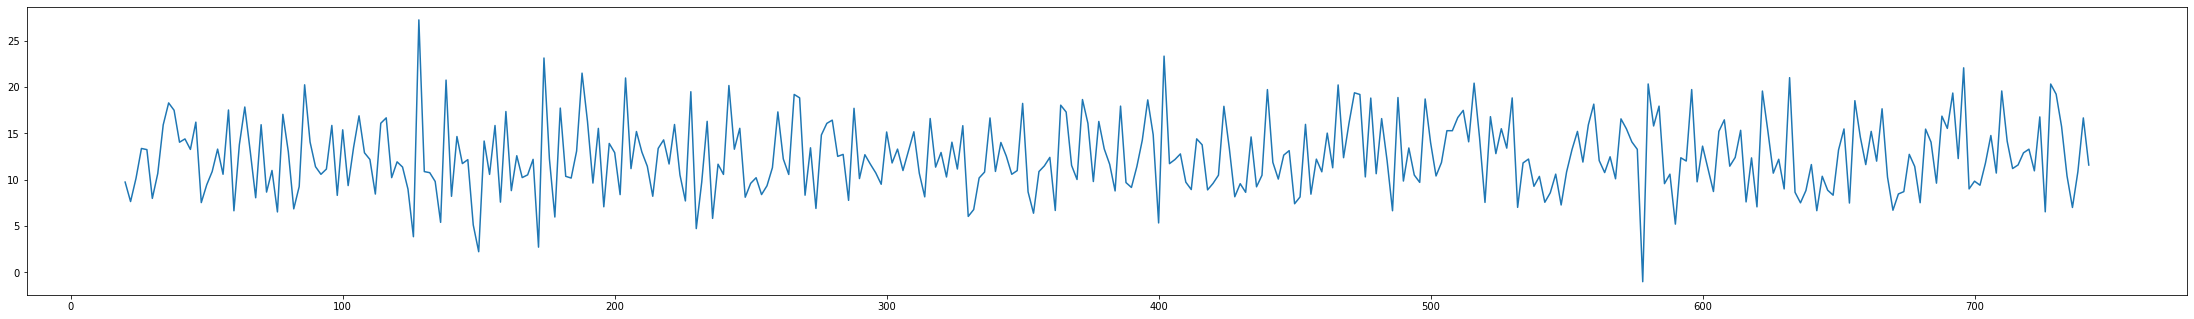

In [18]:
timeSlices = numpy.fromiter(sliceSurprisalList.keys(), dtype=int)

from matplotlib import pyplot

# print(timeSlices)
# print(surprisalList)


plt1 = pyplot.axes([0, 0, 5, 1])
plt1.plot(timeSlices, surprisalList)

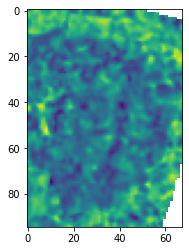

In [45]:
from matplotlib import pylab
pylab.imshow(correlationMatrix[:][:][20])
# pylab.imshow(image[:,:,20,20])

In [33]:
print(image.shape)

(79, 95, 68, 372)
79
